# Hands On Lab: Transfer Learning

This hands-on lab shows how to use [Transfer Learning](https://en.wikipedia.org/wiki/Inductive_transfer) to take an existing trained model and adapt it to your own specialized domain. 

The techniques you will practice are:
* constructing a model and loading pre-trained weights
* adapting the pre-trained model to a new domain, and selective re-training

We assume that you are familiar with basics of deep learning, and these specific concepts:
* Transfer Learning ([Wikipedia page](https://en.wikipedia.org/wiki/Inductive_transfer))

### Prerequisites

We assume that you have already [installed CNTK](https://github.com/Microsoft/CNTK/wiki/Setup-CNTK-on-your-machine).
This tutorial requires CNTK V2. We strongly recommend to run this tutorial on a machine with
a capable CUDA-compatible GPU. Deep learning without GPUs is not fun.


In [17]:
from __future__ import print_function
import glob
import os
import numpy as np
from scipy.io import loadmat
import tarfile
from urllib.request import urlretrieve 
import zipfile

pretrained_models_path = os.path.join('..', 'Examples', 'Image', 'PretrainedModels')
datasets_path = os.path.join('..', 'Examples', 'Image', 'DataSets')
output_path = os.path.join('..', 'Examples', 'Image', 'Output')

def write_to_file(filename, base_path, img_paths, img_labels):
    with open(os.path.join(base_path, filename), 'w+') as f:
        for i in range(0, len(img_paths)):
            f.write('%s\t%s\n' % (os.path.abspath(img_paths[i]), img_labels[i]))

def download_unless_exists(url, filename):
    if os.path.exists(filename):
        print('Reusing locally cached: ', filename)
    else:
        print('Starting download of {} to {}'.format(url, filename))
        urlretrieve(url, filename)
        print('Download completed')
        
def download_model(model_root = pretrained_models_path):
    if not os.path.exists(model_root):
        os.makedirs(model_root)
    resnet18_model_uri = 'https://www.cntk.ai/Models/ResNet/ResNet_18.model'
    resnet18_model_local = os.path.join(model_root, 'ResNet_18.model')
    download_unless_exists(resnet18_model_uri, resnet18_model_local)

def download_flowers_dataset(dataset_root = os.path.join(datasets_path, 'Flowers')):
    if not os.path.exists(dataset_root):
        os.makedirs(dataset_root)
    flowers_uris = [
        'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz',
        'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat',
        'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat'
    ]
    flowers_files = [
        os.path.join(dataset_root, '102flowers.tgz'),
        os.path.join(dataset_root, 'imagelabels.mat'),
        os.path.join(dataset_root, 'setid.mat')
    ]
    for uri, file in zip(flowers_uris, flowers_files):
        download_unless_exists(uri, file)
    tar_dir = os.path.join(dataset_root, 'extracted')
    if not os.path.exists(tar_dir):
        print('Extracting {} to {}'.format(flowers_files[0], tar_dir))
        os.makedirs(tar_dir)
        tarfile.open(flowers_files[0]).extractall(path=tar_dir)
    else:
        print('{} already extracted to {}, using existing version'.format(flowers_files[0], tar_dir))

    if not os.path.exists(os.path.join(dataset_root, '1k_img_map.txt')):
        print('Writing map files ...')
        # get image paths and 0-based image labels
        image_paths = np.array(sorted(glob.glob(os.path.join(tar_dir, 'jpg', '*.jpg'))))
        image_labels = loadmat(flowers_files[1])['labels'][0]
        image_labels -= 1

        # read set information from .mat file
        setid = loadmat(flowers_files[2])
        idx_train = setid['trnid'][0] - 1
        idx_test = setid['tstid'][0] - 1
        idx_val = setid['valid'][0] - 1

        # Confusingly the training set contains 1k images and the test set contains 6k images
        write_to_file('1k_img_map.txt', dataset_root, image_paths[idx_train], image_labels[idx_train])
        write_to_file('6k_img_map.txt', dataset_root, image_paths[idx_test], image_labels[idx_test])
        write_to_file('val_map.txt', dataset_root, image_paths[idx_val], image_labels[idx_val])
        print('Map files written, dataset download and unpack completed.')
    else:
        print('Using cached map files.')
    
def download_animals_dataset(dataset_root = os.path.join(datasets_path, 'Animals')):
    if not os.path.exists(dataset_root):
        os.makedirs(dataset_root)
    animals_uri = 'https://www.cntk.ai/DataSets/Animals/Animals.zip'
    animals_file = os.path.join(dataset_root, 'Animals.zip')
    download_unless_exists(animals_uri, animals_file)
    if not os.path.exists(os.path.join(dataset_root, 'Test')):
        with zipfile.ZipFile(animals_file) as animals_zip:
            print('Extracting {} to {}'.format(animals_file, dataset_root))
            animals_zip.extractall(path=os.path.join(dataset_root, '..'))
            print('Extraction completed.')
    else:
        print('Using previously extracted Animals data.')

print('Downloading pre-trained model and data-set, this might take a while...')
download_model()
download_flowers_dataset()
download_animals_dataset()

Reusing locally cached:  ..\Examples\Image\PretrainedModels\ResNet_18.model
Reusing locally cached:  ..\Examples\Image\DataSets\Flowers\102flowers.tgz
Reusing locally cached:  ..\Examples\Image\DataSets\Flowers\imagelabels.mat
Reusing locally cached:  ..\Examples\Image\DataSets\Flowers\setid.mat
..\Examples\Image\DataSets\Flowers\102flowers.tgz already extracted to ..\Examples\Image\DataSets\Flowers\extracted, using existing version
Using cached map files.
Reusing locally cached:  ..\Examples\Image\DataSets\Animals\Animals.zip
Using previously extracted Animals data.


### The Flowers Dataset

The Flowers dataset comes from the Oxford Visual Geometry Group, and contains 102 different categories of flowers common to the UK. It has roughly 8000 images split between train, test, and validation sets. The [VGG homepage for the dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) contains more details.

Let's take a look at some of the data we'll be working with:

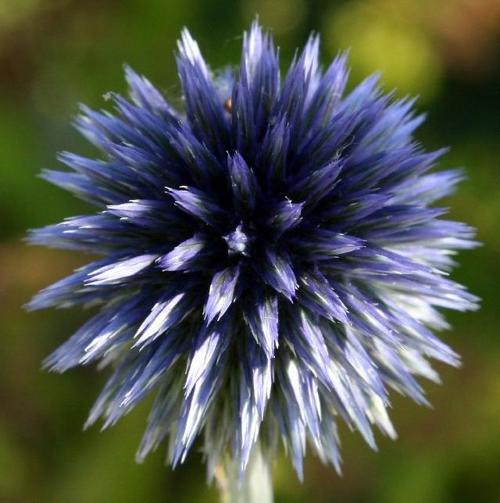

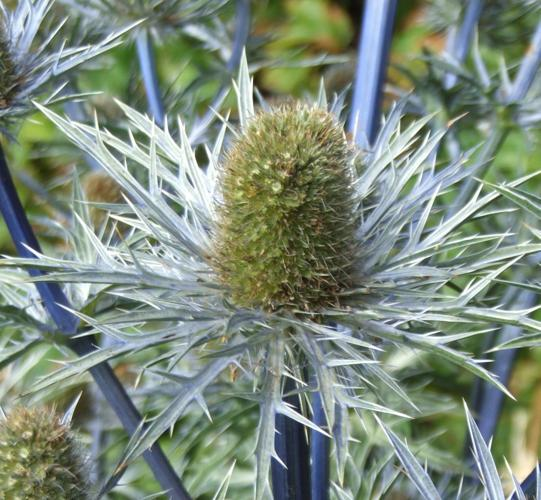

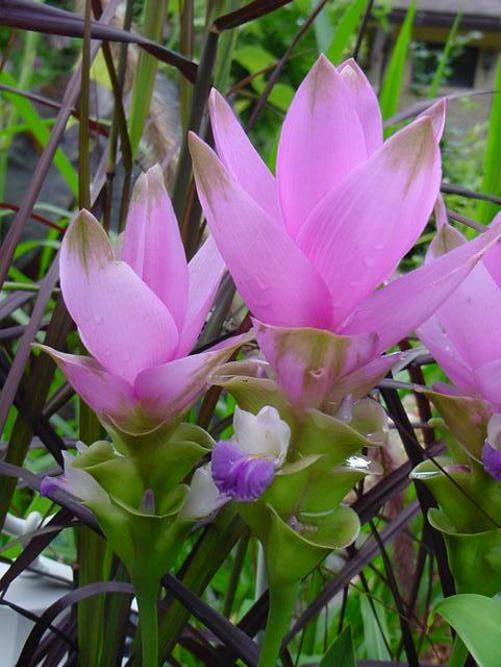

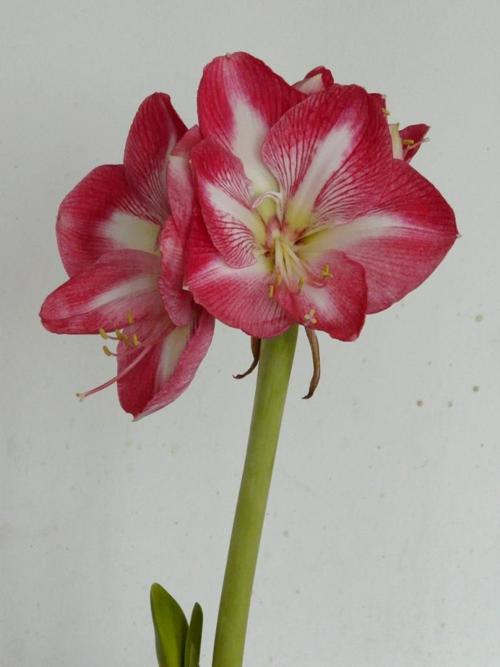

In [18]:
from IPython.display import display, Image

image_dir = os.path.join('..', 'Examples', 'Image', 'DataSets', 'Flowers', 'extracted', 'jpg')
images = ['08093', '08084', '08081', '08058']
for image in images:
    display(Image(os.path.join(image_dir, 'image_{}.jpg'.format(image)), width=100, height=100))

### Transfer Learning

With Transfer Learning, we use an existing trained model and adapt it to our own domain. We are essentially building upon the features and concepts that were learned during the training of the base model. With a Convolutional DNN (ResNet_18 in this case), we're using the features learned from ImageNet data and _cutting off_ the final classification layer, replacing it with a new dense layer that will predict the class labels of our new domain. 

The input to the old and the new prediction layer is the same, we simply reuse the trained features. Then we train this modified network, either only the new weights of the new prediction layer or all weights of the entire network.

In the code below, we load up ResNet_18 and clone it (optionally freezing the trained weights), while stripping off the final `features` layer. We do this by finding the final hidden layer (`z.x`) using `find_by_name`, clone, then attach a new `Dense` layer for classification. We print out all of the layers in ResNet_18 to show you how you can interrogate a model - to use a different model than ResNet_18 you would just need to discover the appropriate last hidden layer and feature layer to use.

In [19]:
from PIL import Image
from cntk.device import set_default_device, gpu
from cntk import load_model, Trainer, UnitType
from cntk.layers import Placeholder, Constant
from cntk.graph import find_by_name, get_node_outputs
from cntk.io import MinibatchSource, ImageDeserializer
from cntk.layers import Dense
from cntk.learner import momentum_sgd, learning_rate_schedule, momentum_schedule
from cntk.ops import input_variable, cross_entropy_with_softmax, classification_error, combine, softmax
from cntk.ops.functions import CloneMethod
from cntk.utils import log_number_of_parameters, ProgressPrinter

################################################
################################################
# general settings
make_mode = False
freeze_weights = False
if not os.path.exists(output_path):
    os.makedirs(output_path)
flowers_model_file = os.path.join(output_path, 'FlowersTransferLearning.model')
flowers_results_file = os.path.join(output_path, 'FlowersPredictions.txt')
features_stream_name = 'features'
label_stream_name = 'labels'
new_output_node_name = 'prediction'

# Learning parameters
max_epochs = 20
mb_size = 50
lr_per_mb = [0.2]*10 + [0.1]
momentum_per_mb = 0.9
l2_reg_weight = 0.0005

# define base model location and characteristics
_base_model_file = os.path.join(pretrained_models_path, 'ResNet_18.model')

# TODO: This results in AttributeError: Function does not have 'is_parameter' and it cannot be looked up in its outputs because it does not have exactly one
# Print out all layers in the model
#print('Loading {} and printing all layers:'.format(_base_model_file))
#node_outputs = get_node_outputs(load_model(_base_model_file))
#for l in node_outputs: print("  {0} {1}".format(l.name, l.shape))

_feature_node_name = 'features'
_last_hidden_node_name = 'z.x'
_image_height = 224
_image_width = 224
_num_channels = 3

# define data location and characteristics
_data_folder = os.path.join(datasets_path, 'Flowers')
_train_map_file = os.path.join(_data_folder, '6k_img_map.txt')
_test_map_file = os.path.join(_data_folder, '1k_img_map.txt')
_num_classes = 102
################################################
################################################


# Creates a minibatch source for training or testing
def create_mb_source(map_file, image_width, image_height, num_channels, num_classes, randomize=True):
    transforms = [ImageDeserializer.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear')]
    image_source = ImageDeserializer(map_file)
    image_source.map_features(features_stream_name, transforms)
    image_source.map_labels(label_stream_name, num_classes)
    return MinibatchSource(image_source, randomize=randomize)


# Creates the network model for transfer learning
def create_model(base_model_file, feature_node_name, last_hidden_node_name, num_classes, input_features, freeze=False):
    # Load the pretrained classification net and find nodes
    base_model   = load_model(base_model_file)        
    feature_node = find_by_name(base_model, feature_node_name)
    last_node    = find_by_name(base_model, last_hidden_node_name)

    # Clone the desired layers with fixed weights
    cloned_layers = combine([last_node.owner]).clone(
        CloneMethod.freeze if freeze else CloneMethod.clone,
        {feature_node: Placeholder(name='features')})

    # Add new dense layer for class prediction
    feat_norm  = input_features - Constant(114)
    cloned_out = cloned_layers(feat_norm)
    z          = Dense(num_classes, activation=None, name=new_output_node_name) (cloned_out)

    return z


We will now train the model just like any other CNTK model training - instantiating an input source (in this case a `MinibatchSource` from our image data), defining the loss function, and training for a number of epochs. 

In [20]:
# Trains a transfer learning model
def train_model(base_model_file, feature_node_name, last_hidden_node_name,
                image_width, image_height, num_channels, num_classes, train_map_file,
                num_epochs, max_images=-1, freeze=False):
    epoch_size = sum(1 for line in open(train_map_file))
    if max_images > 0:
        epoch_size = min(epoch_size, max_images)

    # Create the minibatch source and input variables
    minibatch_source = create_mb_source(train_map_file, image_width, image_height, num_channels, num_classes)
    image_input = input_variable((num_channels, image_height, image_width))
    label_input = input_variable(num_classes)

    # Define mapping from reader streams to network inputs
    input_map = {
        image_input: minibatch_source[features_stream_name],
        label_input: minibatch_source[label_stream_name]
    }

    # Instantiate the transfer learning model and loss function
    tl_model = create_model(base_model_file, feature_node_name, last_hidden_node_name, num_classes, image_input, freeze)
    ce = cross_entropy_with_softmax(tl_model, label_input)
    pe = classification_error(tl_model, label_input)

    # Instantiate the trainer object
    lr_schedule = learning_rate_schedule(lr_per_mb, unit=UnitType.minibatch)
    mm_schedule = momentum_schedule(momentum_per_mb)
    learner = momentum_sgd(tl_model.parameters, lr_schedule, mm_schedule, l2_regularization_weight=l2_reg_weight)
    trainer = Trainer(tl_model, (ce, pe), learner)

    # Get minibatches of images and perform model training
    print("Training transfer learning model for {0} epochs (epoch_size = {1}).".format(num_epochs, epoch_size))
    log_number_of_parameters(tl_model)
    progress_printer = ProgressPrinter(tag='Training', num_epochs=num_epochs)
    for epoch in range(num_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            data = minibatch_source.next_minibatch(min(mb_size, epoch_size-sample_count), input_map=input_map)
            trainer.train_minibatch(data)                                    # update model with it
            sample_count += trainer.previous_minibatch_sample_count          # count samples processed so far
            progress_printer.update_with_trainer(trainer, with_metric=True)  # log progress
            if sample_count % (100 * mb_size) == 0:
                print ("Processed {0} samples".format(sample_count))

        progress_printer.epoch_summary(with_metric=True)

    return tl_model


When we evaluate the trained model on an image, we have to massage that image into the expected format. In our case we use `Image` to load the image from its path, resize it to the size expected by our model, reverse the color channels (RGB to BGR), and convert to a contiguous array along height, width, and color channels. This corresponds to the 255x255x3 flattened array on which our model was trained.

In [21]:
# Evaluates a single image using the provided model
def eval_single_image(loaded_model, image_path, image_width, image_height):
    # load and format image (resize, RGB -> BGR, CHW -> HWC)
    img = Image.open(image_path)
    if image_path.endswith("png"):
        temp = Image.new("RGB", img.size, (255, 255, 255))
        temp.paste(img, img)
        img = temp
    resized = img.resize((image_width, image_height), Image.ANTIALIAS)
    bgr_image = np.asarray(resized, dtype=np.float32)[..., [2, 1, 0]]
    hwc_format = np.ascontiguousarray(np.rollaxis(bgr_image, 2))

    # compute model output
    arguments = {loaded_model.arguments[0]: [hwc_format]}
    output = loaded_model.eval(arguments)

    # return softmax probabilities
    sm = softmax(output[0, 0])
    return sm.eval()


# Evaluates an image set using the provided model
def eval_test_images(loaded_model, output_file, test_map_file, image_width, image_height, max_images=-1, column_offset=0):
    num_images = sum(1 for line in open(test_map_file))
    if max_images > 0:
        num_images = min(num_images, max_images)
    print("Evaluating model output node '{0}' for {1} images.".format(new_output_node_name, num_images))

    pred_count = 0
    correct_count = 0
    np.seterr(over='raise')
    with open(output_file, 'wb') as results_file:
        with open(test_map_file, "r") as input_file:
            for line in input_file:
                tokens = line.rstrip().split('\t')
                img_file = tokens[0 + column_offset]
                probs = eval_single_image(loaded_model, img_file, image_width, image_height)

                pred_count += 1
                true_label = int(tokens[1 + column_offset])
                predicted_label = np.argmax(probs)
                if predicted_label == true_label:
                    correct_count += 1

                np.savetxt(results_file, probs[np.newaxis], fmt="%.3f")
                if pred_count % 100 == 0:
                    print("Processed {0} samples ({1} correct)".format(pred_count, (correct_count / pred_count)))
                if pred_count >= num_images:
                    break

    print ("{0} of {1} prediction were correct {2}.".format(correct_count, pred_count, (correct_count / pred_count)))


Finally, we train the model and evaluate it on our flower dataset.

In [22]:
set_default_device(gpu(0))

# Train only if no model exists yet or if make_mode is set to False
if os.path.exists(flowers_model_file) and make_mode:
    print("Loading existing model from %s" % flowers_model_file)
    trained_model = load_model(flowers_model_file)
else:
    trained_model = train_model(_base_model_file, _feature_node_name, _last_hidden_node_name,
                                _image_width, _image_height, _num_channels, _num_classes, _train_map_file,
                                max_epochs, freeze=freeze_weights)
    trained_model.save(flowers_model_file)
    print("Stored trained model at %s" % flowers_model_file)

# Evaluate the test set
eval_test_images(trained_model, flowers_results_file, _test_map_file, _image_width, _image_height)

print("Done. Wrote output to %s" % flowers_results_file)

Training transfer learning model for 20 epochs (epoch_size = 6149).
Training 15949478 parameters in 68 parameter tensors.
Processed 5000 samples
Finished Epoch[1 of 20]: [Training] loss = 1.880528 * 6149, metric = 43.4% * 6149 57.435s (107.1 samples per second);
Processed 5000 samples
Finished Epoch[2 of 20]: [Training] loss = 0.384004 * 6149, metric = 10.8% * 6149 53.188s (115.6 samples per second);
Processed 5000 samples
Finished Epoch[3 of 20]: [Training] loss = 0.118894 * 6149, metric = 3.2% * 6149 53.836s (114.2 samples per second);
Processed 5000 samples
Finished Epoch[4 of 20]: [Training] loss = 0.051257 * 6149, metric = 1.3% * 6149 54.238s (113.4 samples per second);
Processed 5000 samples
Finished Epoch[5 of 20]: [Training] loss = 0.016201 * 6149, metric = 0.4% * 6149 54.271s (113.3 samples per second);
Processed 5000 samples
Finished Epoch[6 of 20]: [Training] loss = 0.004814 * 6149, metric = 0.0% * 6149 54.115s (113.6 samples per second);
Processed 5000 samples
Finished Epoc

### Animals Dataset

With the Flowers dataset, we had hundreds of classes with hundreds of images. What if we had a smaller set of classes and images to work with, would transfer learning still work? Let's examine the Animals dataset we've downloaded, consisting of nothing but sheep and wolves and a much smaller set of images to work with (on the order of a dozen per class). 

The images are stored in `Train` and `Test` folders with the nested folder giving the class name (i.e. `Sheep` and `Wolf` folders). This is quite common, so it's useful to know how to convert that format into one that can be used for constructing the mapping files CNTK expects. `create_class_mapping_from_folder` looks at all nested folders in the root and turns their names into labels, and returns this as an array used by `create_map_file_from_folder`. That method walks those folders and writes their paths and label indices into a `map.txt` file in the root (e.g. `Train`, `Test`). Note the use of `abspath`, allowing you to specify relative "root" paths to the method, and then move the resulting map files or run from different directories without issue. 

In [26]:
animals_train_path = os.path.join(datasets_path, 'Animals', 'Train')
animals_test_path = os.path.join(datasets_path, 'Animals', 'Test')

def create_map_file_from_folder(root_folder, class_mapping, include_unknown=False, valid_extensions=['.jpg', '.jpeg', '.png']):
    map_file_name = os.path.join(root_folder, "map.txt")
    with open(map_file_name , 'w') as map_file:
        for class_id in range(0, len(class_mapping)):
            folder = os.path.join(root_folder, class_mapping[class_id])
            if os.path.exists(folder):
                for entry in os.listdir(folder):
                    filename = os.path.abspath(os.path.join(folder, entry))
                    if os.path.isfile(filename) and os.path.splitext(filename)[1].lower() in valid_extensions:
                        map_file.write("{0}\t{1}\n".format(filename, class_id))

        if include_unknown:
            for entry in os.listdir(root_folder):
                filename = os.path.abspath(os.path.join(root_folder, entry))
                if os.path.isfile(filename) and os.path.splitext(filename)[1].lower() in valid_extensions:
                    map_file.write("{0}\t-1\n".format(filename))

    return map_file_name


def create_class_mapping_from_folder(root_folder):
    classes = []
    for _, directories, _ in os.walk(root_folder):
        for directory in directories:
            classes.append(directory)
    return np.asarray(classes)

class_mapping = create_class_mapping_from_folder(animals_train_path)
train_map_file = create_map_file_from_folder(animals_train_path, class_mapping)
test_map_file = create_map_file_from_folder(animals_test_path, class_mapping, include_unknown=True)

We can now train our model on our small domain and evaluate the results:

In [29]:
animals_model_file = os.path.join(output_path, 'AnimalsTransferLearning.model')

if os.path.exists(animals_model_file) and make_mode:
    print("Loading existing model from %s" % animals_model_file)
    trained_model = load_model(animals_model_file)
else:
    trained_model = train_model(_base_model_file, _feature_node_name, _last_hidden_node_name,
                                _image_width, _image_height, _num_channels, len(class_mapping), train_map_file,
                                num_epochs=30, freeze=freeze_weights)
    trained_model.save(animals_model_file)
    print("Stored trained model at %s" % animals_model_file)

# evaluate test images
with open(animals_results_file, 'w') as output_file:
    with open(test_map_file, "r") as input_file:
        for line in input_file:
            tokens = line.rstrip().split('\t')
            img_file = tokens[0]
            true_label = int(tokens[1])
            probs = eval_single_image(trained_model, img_file, _image_width, _image_height)

            class_probs = np.column_stack((probs, class_mapping)).tolist()
            class_probs.sort(key=lambda x: float(x[0]), reverse=True)
            predictions = ' '.join(
                ['%s:%.3f' % (class_probs[i][1], float(class_probs[i][0])) for i in range(0, len(class_mapping))])
            true_class_name = class_mapping[true_label] if true_label >= 0 else 'unknown'
            print('Class: %s, predictions: %s, image: %s' % (true_class_name, predictions, img_file))

Training transfer learning model for 30 epochs (epoch_size = 30).
Training 15898178 parameters in 68 parameter tensors.
Finished Epoch[1 of 30]: [Training] loss = 2.185084 * 30, metric = 53.3% * 30 0.000s (  0.0 samples per second);
Finished Epoch[2 of 30]: [Training] loss = 0.031899 * 30, metric = 0.0% * 30 5.963s (  5.0 samples per second);
Finished Epoch[3 of 30]: [Training] loss = 0.383777 * 30, metric = 23.3% * 30 0.208s (143.9 samples per second);
Finished Epoch[4 of 30]: [Training] loss = 0.001013 * 30, metric = 0.0% * 30 0.238s (125.8 samples per second);
Finished Epoch[5 of 30]: [Training] loss = 0.000355 * 30, metric = 0.0% * 30 0.238s (126.3 samples per second);
Finished Epoch[6 of 30]: [Training] loss = 0.000241 * 30, metric = 0.0% * 30 0.221s (135.7 samples per second);
Finished Epoch[7 of 30]: [Training] loss = 0.000185 * 30, metric = 0.0% * 30 0.223s (134.5 samples per second);
Finished Epoch[8 of 30]: [Training] loss = 0.000150 * 30, metric = 0.0% * 30 0.260s (115.4 sam

Note the `include_unknown=True` in the `test_map_file` creation. This is because we have a few unlabeled images in that directory - these get tagged with label `-1`, which will never be matched by the evaluator. This is just to show that if you train a classifier to only find sheep and wolves, it will always find sheep and wolves. Showing it pictures of birds like our unknown examples will only result in confusion, as you can see above where the images of birds are falsely predicted.

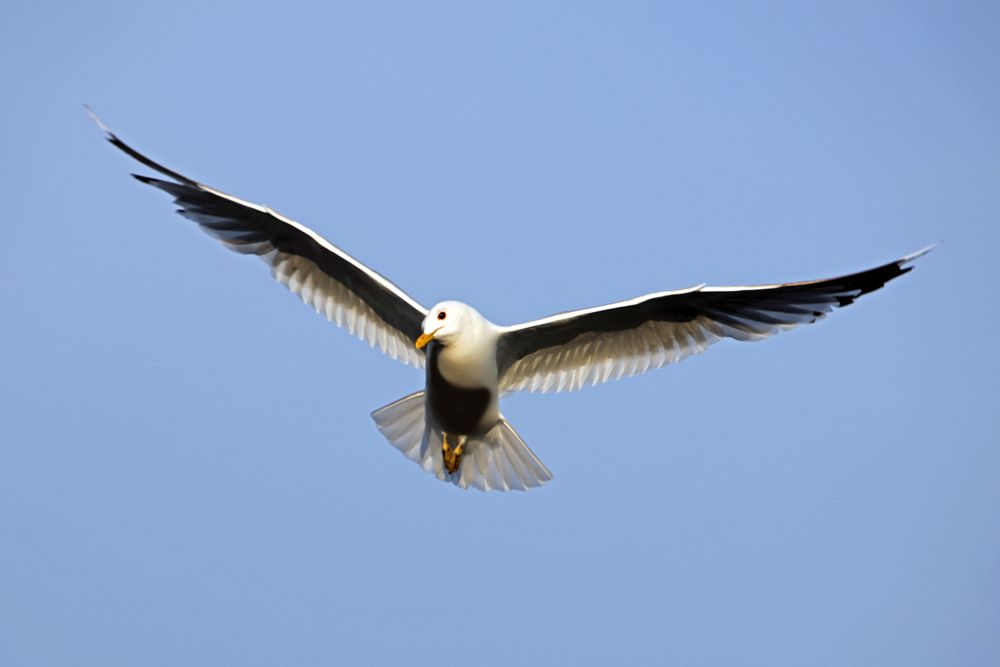

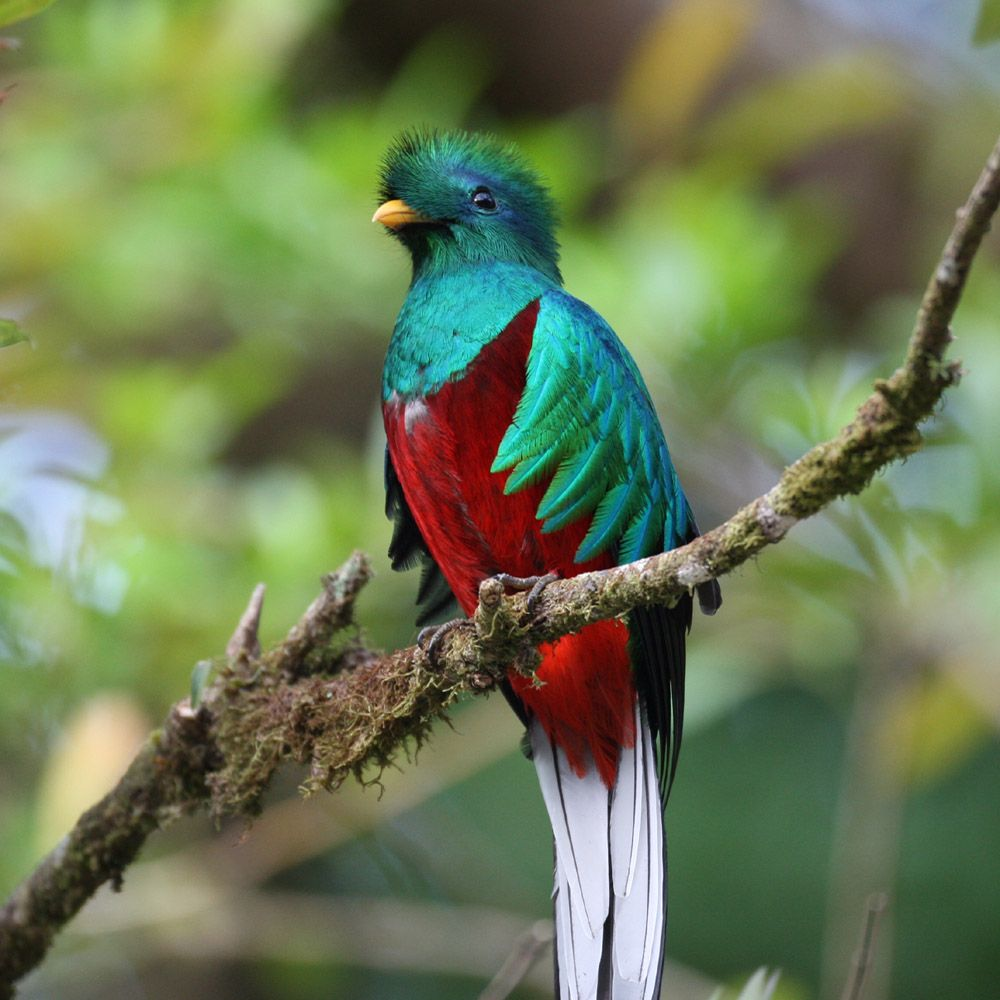

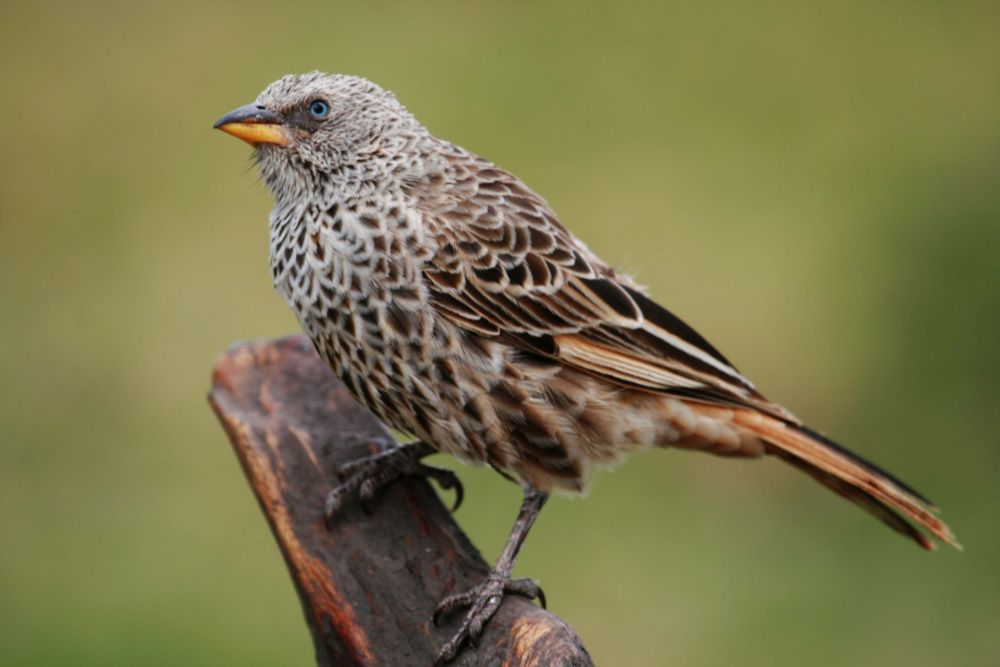

In [32]:
from IPython.display import display, Image

image_dir = os.path.join('..', 'Examples', 'Image', 'DataSets', 'Animals', 'Test')
images = ['Bird_in_flight_wings_spread.jpg', 'quetzal-bird.jpg', 'Weaver_bird.jpg']
for image in images:
    display(Image(os.path.join(image_dir, image), width=100, height=100))

### Final Thoughts, and Caveats

Transfer Learning has limitations. If you noticed, we re-trained a model that had been trained on ImageNet images. This meant it already _knew_ what "images" were, and had a good idea on concepts from low-level (stripes, circles) to high-level (dog's noses, cat's ears). Re-training such a model to detect sheep or wolves makes sense, but re-training it to detect vehicles from aerial imagery would be more difficult. You can still use Transfer Learning in these cases, but you might want to just re-use earlier layers of the model (i.e. the early Convolutional layers that have learned more primitive concepts), and you'll likely require much more training data.

Adding a catch-all category can be a good idea, but only if the training data for that category contains images that are again sufficiently similar to the images you expect at scoring time. As in the above example, if we train a classifier with images of sheep and wolf and use it to score an image of a bird, the classifier can still only assign a sheep or wolf label, since it doesn't know any other categories. If we were to add a catch-all category and add training images of birds to it then the classifier might predict the class correctly for the bird image. However, if we present it, e.g., an image of a car, it faces the same problem as before as it knows only sheep, wolf and bird (which we just happened to call called catch-all). Hence, your training data, even for your catch-all, needs to cover sufficiently those concepts and images that you expect later on at scoring time.